In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap


In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier, NeighborhoodComponentsAnalysis, LocalOutlierFactor
from sklearn.decomposition import PCA

In [3]:
# warning library
import warnings
warnings.filterwarnings("ignore")


In [4]:
data = pd.read_csv("cancer.csv")
data.drop(['Unnamed: 32','id'], inplace = True, axis = 1)

In [6]:
data = data.rename(columns = {"diagnosis":"target"})

target
B    357
M    212
Name: count, dtype: int64


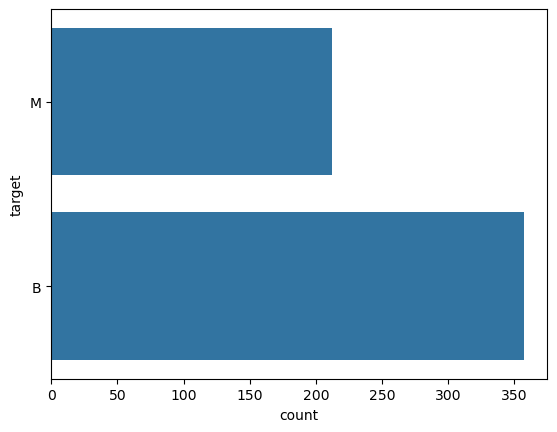

In [7]:
sns.countplot(data["target"])
print(data.target.value_counts())

In [8]:
data["target"] = [1 if i.strip() == "M" else 0 for i in data.target]

In [9]:
print(len(data))

print(data.head())

print("Data shape ", data.shape)

569
   target  radius_mean  texture_mean  perimeter_mean  area_mean  \
0       1        17.99         10.38          122.80     1001.0   
1       1        20.57         17.77          132.90     1326.0   
2       1        19.69         21.25          130.00     1203.0   
3       1        11.42         20.38           77.58      386.1   
4       1        20.29         14.34          135.10     1297.0   

   smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
0          0.11840           0.27760          0.3001              0.14710   
1          0.08474           0.07864          0.0869              0.07017   
2          0.10960           0.15990          0.1974              0.12790   
3          0.14250           0.28390          0.2414              0.10520   
4          0.10030           0.13280          0.1980              0.10430   

   symmetry_mean  ...  radius_worst  texture_worst  perimeter_worst  \
0         0.2419  ...         25.38          17.33         

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   target                   569 non-null    int64  
 1   radius_mean              569 non-null    float64
 2   texture_mean             569 non-null    float64
 3   perimeter_mean           569 non-null    float64
 4   area_mean                569 non-null    float64
 5   smoothness_mean          569 non-null    float64
 6   compactness_mean         569 non-null    float64
 7   concavity_mean           569 non-null    float64
 8   concave points_mean      569 non-null    float64
 9   symmetry_mean            569 non-null    float64
 10  fractal_dimension_mean   569 non-null    float64
 11  radius_se                569 non-null    float64
 12  texture_se               569 non-null    float64
 13  perimeter_se             569 non-null    float64
 14  area_se                  5

In [12]:
describe = data.describe()

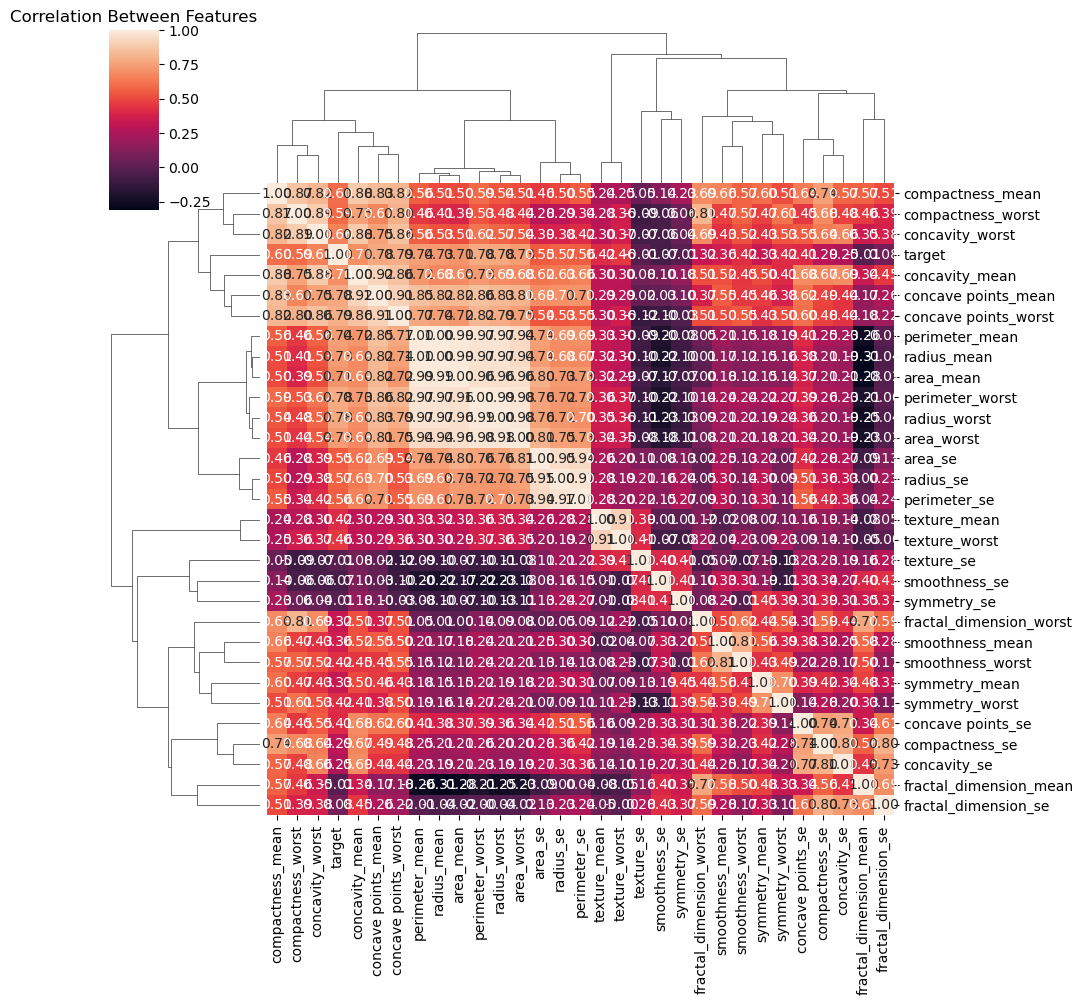

In [13]:
# Correlation
corr_matrix = data.corr()
sns.clustermap(corr_matrix, annot = True, fmt = ".2f")
plt.title("Correlation Between Features")
plt.show()

Text(0.5, 1.0, 'Correlation Between Features w Corr Threshold 0.75')

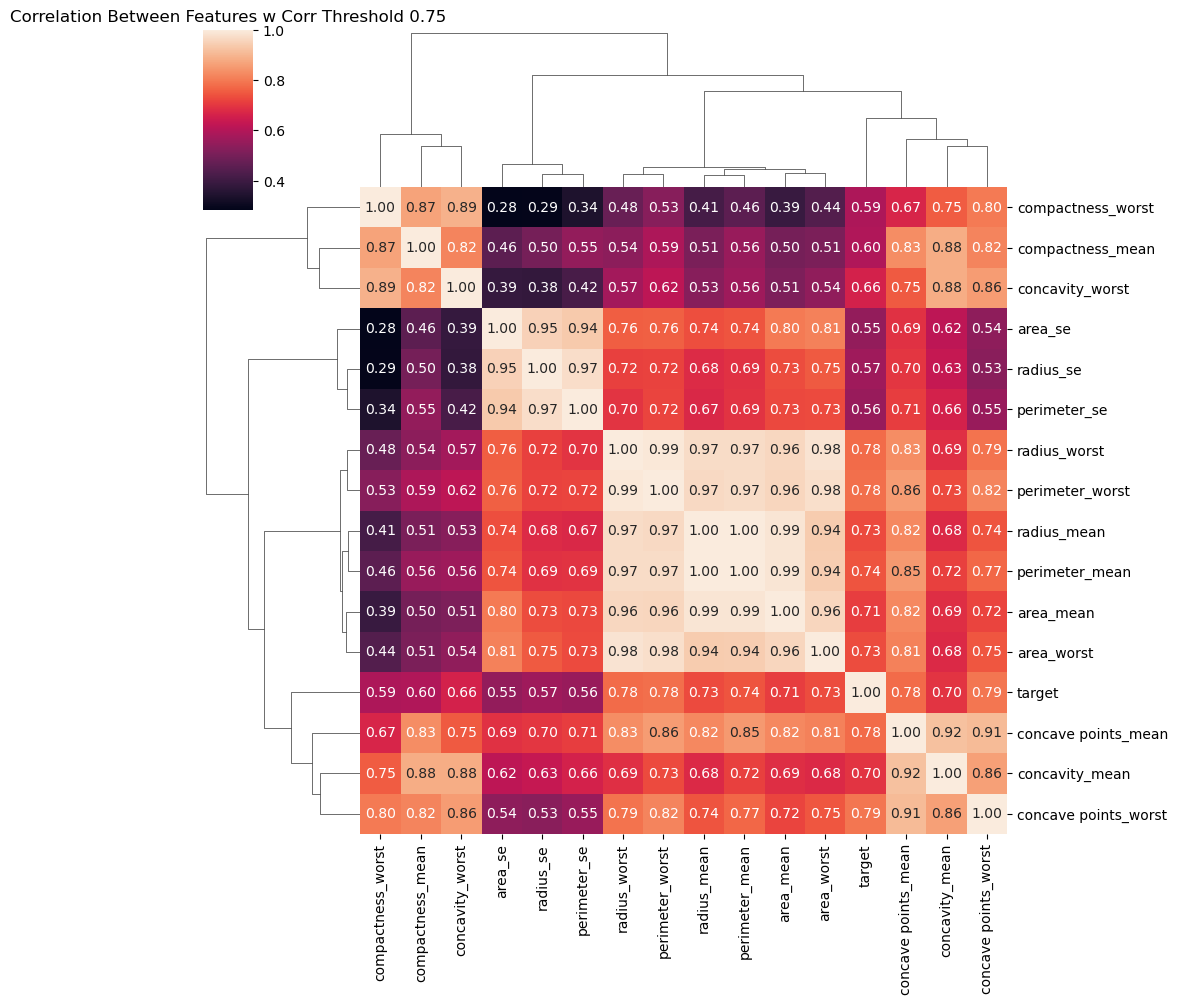

In [14]:
threshold = 0.5
filtre = np.abs(corr_matrix["target"]) > threshold
corr_features = corr_matrix.columns[filtre].tolist()
sns.clustermap(data[corr_features].corr(), annot = True, fmt = ".2f")
plt.title("Correlation Between Features w Corr Threshold 0.75")

In [15]:
# box plot 
data_melted = pd.melt(data, id_vars = "target",
                      var_name = "features",
                      value_name = "value")

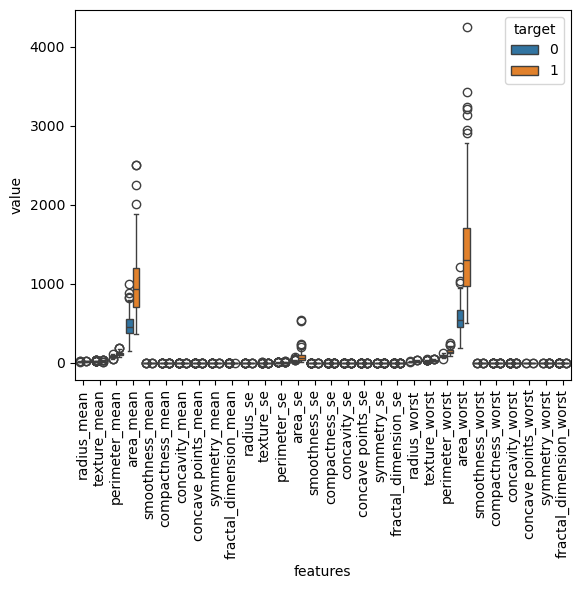

In [16]:
plt.figure()
sns.boxplot(x = "features", y = "value", hue = "target", data = data_melted)
plt.xticks(rotation = 90)
plt.show()

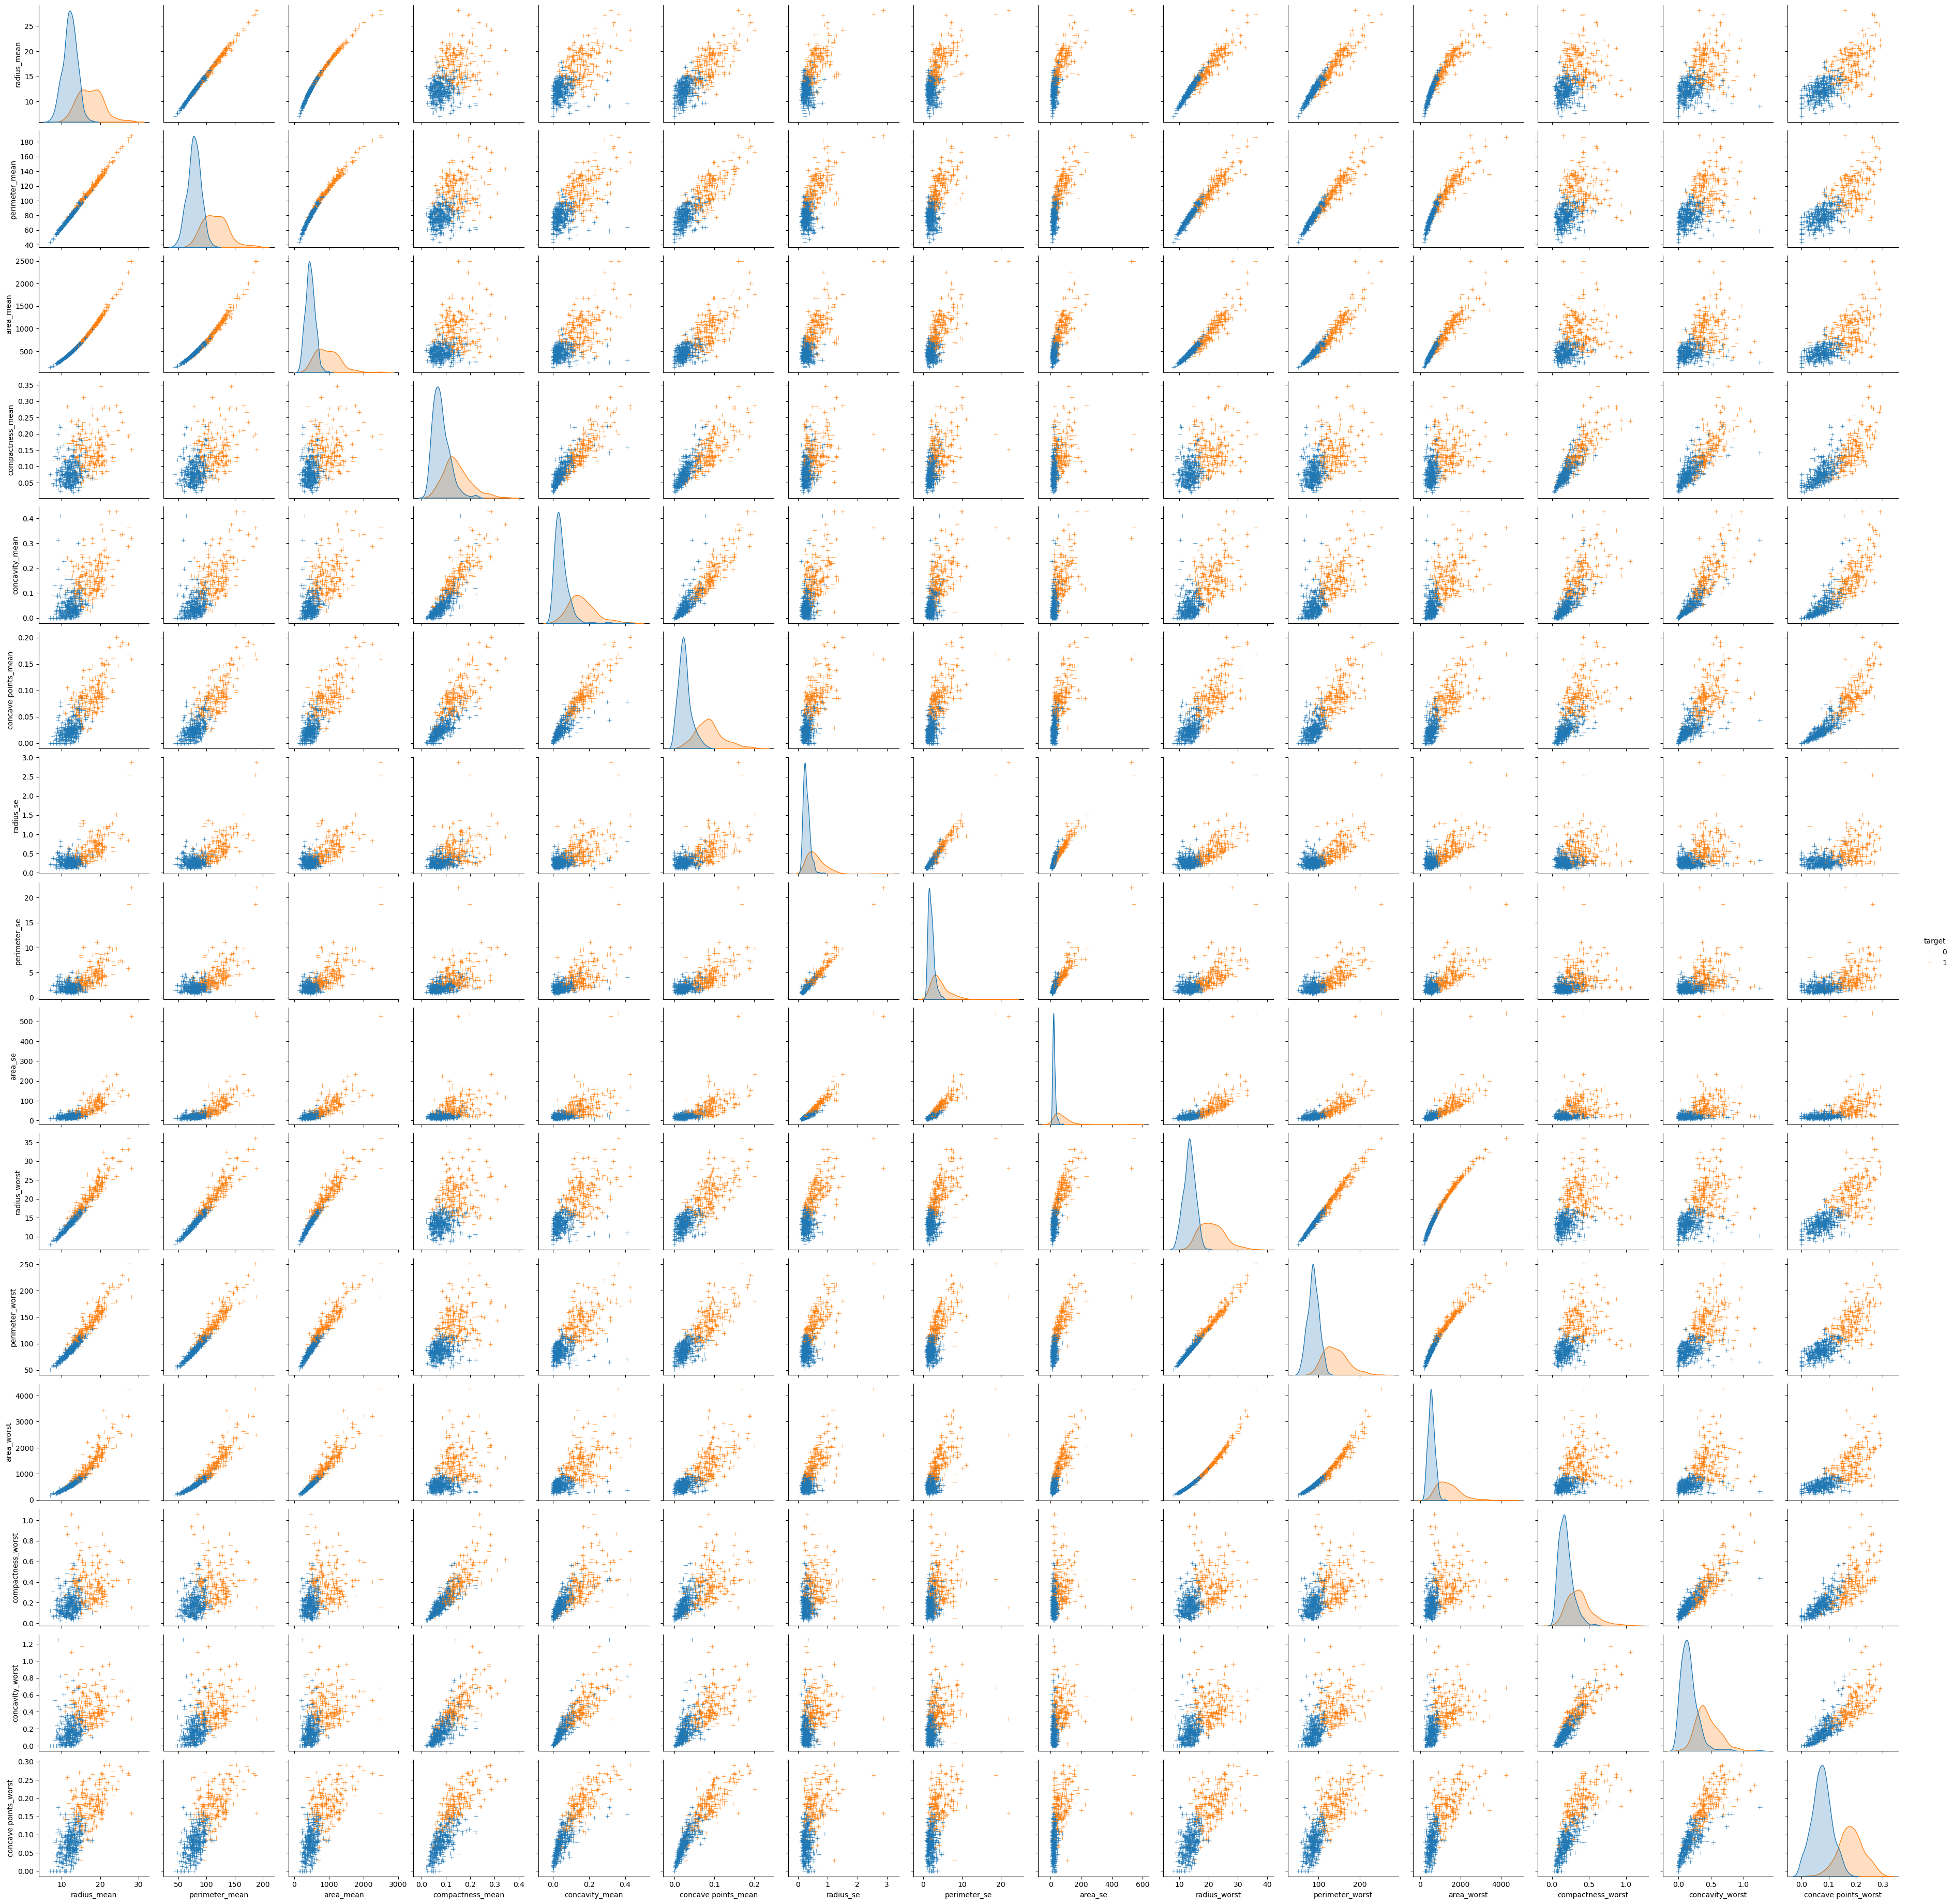

In [17]:
"""
standardization-normalization
"""

# pair plot 
sns.pairplot(data[corr_features], diag_kind = "kde", markers = "+",hue = "target")
plt.show()

In [18]:
# %% outlier
y = data.target
x = data.drop(["target"],axis = 1)
columns = x.columns.tolist()

In [19]:
clf = LocalOutlierFactor()
y_pred = clf.fit_predict(x)
X_score = clf.negative_outlier_factor_

In [20]:
outlier_score = pd.DataFrame()
outlier_score["score"] = X_score

In [21]:
# threshold
threshold = -2.5
filtre = outlier_score["score"] < threshold
outlier_index = outlier_score[filtre].index.tolist()

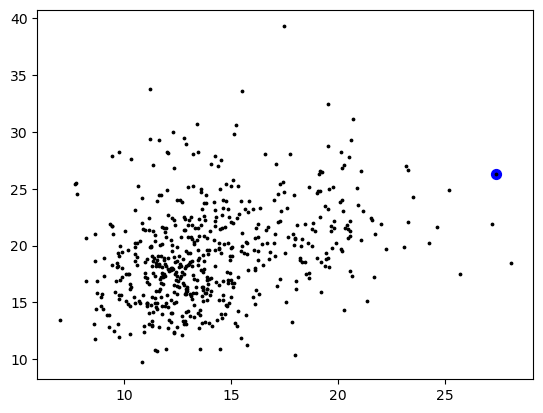

In [22]:
plt.figure()
plt.scatter(x.iloc[outlier_index,0], x.iloc[outlier_index,1],color = "blue", s = 50, label = "Outliers")
plt.scatter(x.iloc[:,0], x.iloc[:,1], color = "k", s = 3, label = "Data Points")

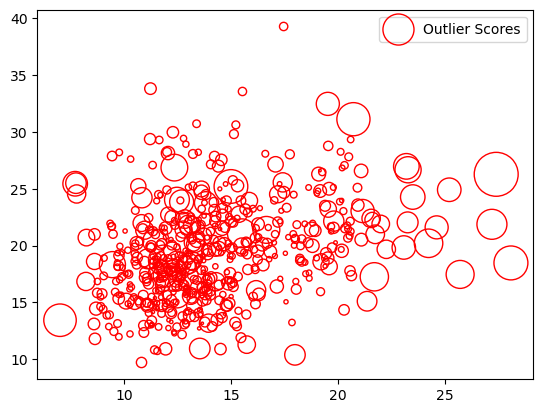

In [23]:
radius = (X_score.max() - X_score)/(X_score.max() - X_score.min())
outlier_score["radius"] = radius
plt.scatter(x.iloc[:,0], x.iloc[:,1], s = 1000*radius, edgecolors = "r",facecolors = "none", label = "Outlier Scores")
plt.legend()
plt.show()


In [24]:
# %% Train test split
test_size = 0.25
X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size = test_size, random_state = 42)

In [25]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [26]:
X_train_df = pd.DataFrame(X_train, columns = columns)
X_train_df_describe = X_train_df.describe()
X_train_df["target"] = Y_train

In [27]:
# box plot 
data_melted = pd.melt(X_train_df, id_vars = "target",
                      var_name = "features",
                      value_name = "value")

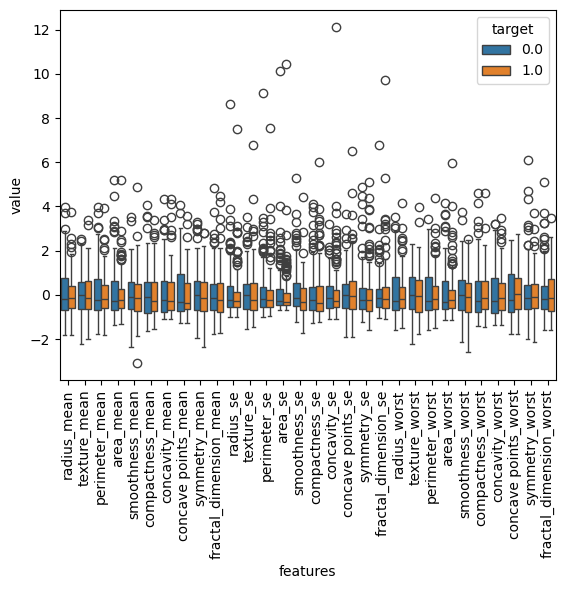

In [28]:
plt.figure()
sns.boxplot(x = "features", y = "value", hue = "target", data = data_melted)
plt.xticks(rotation = 90)
plt.show()

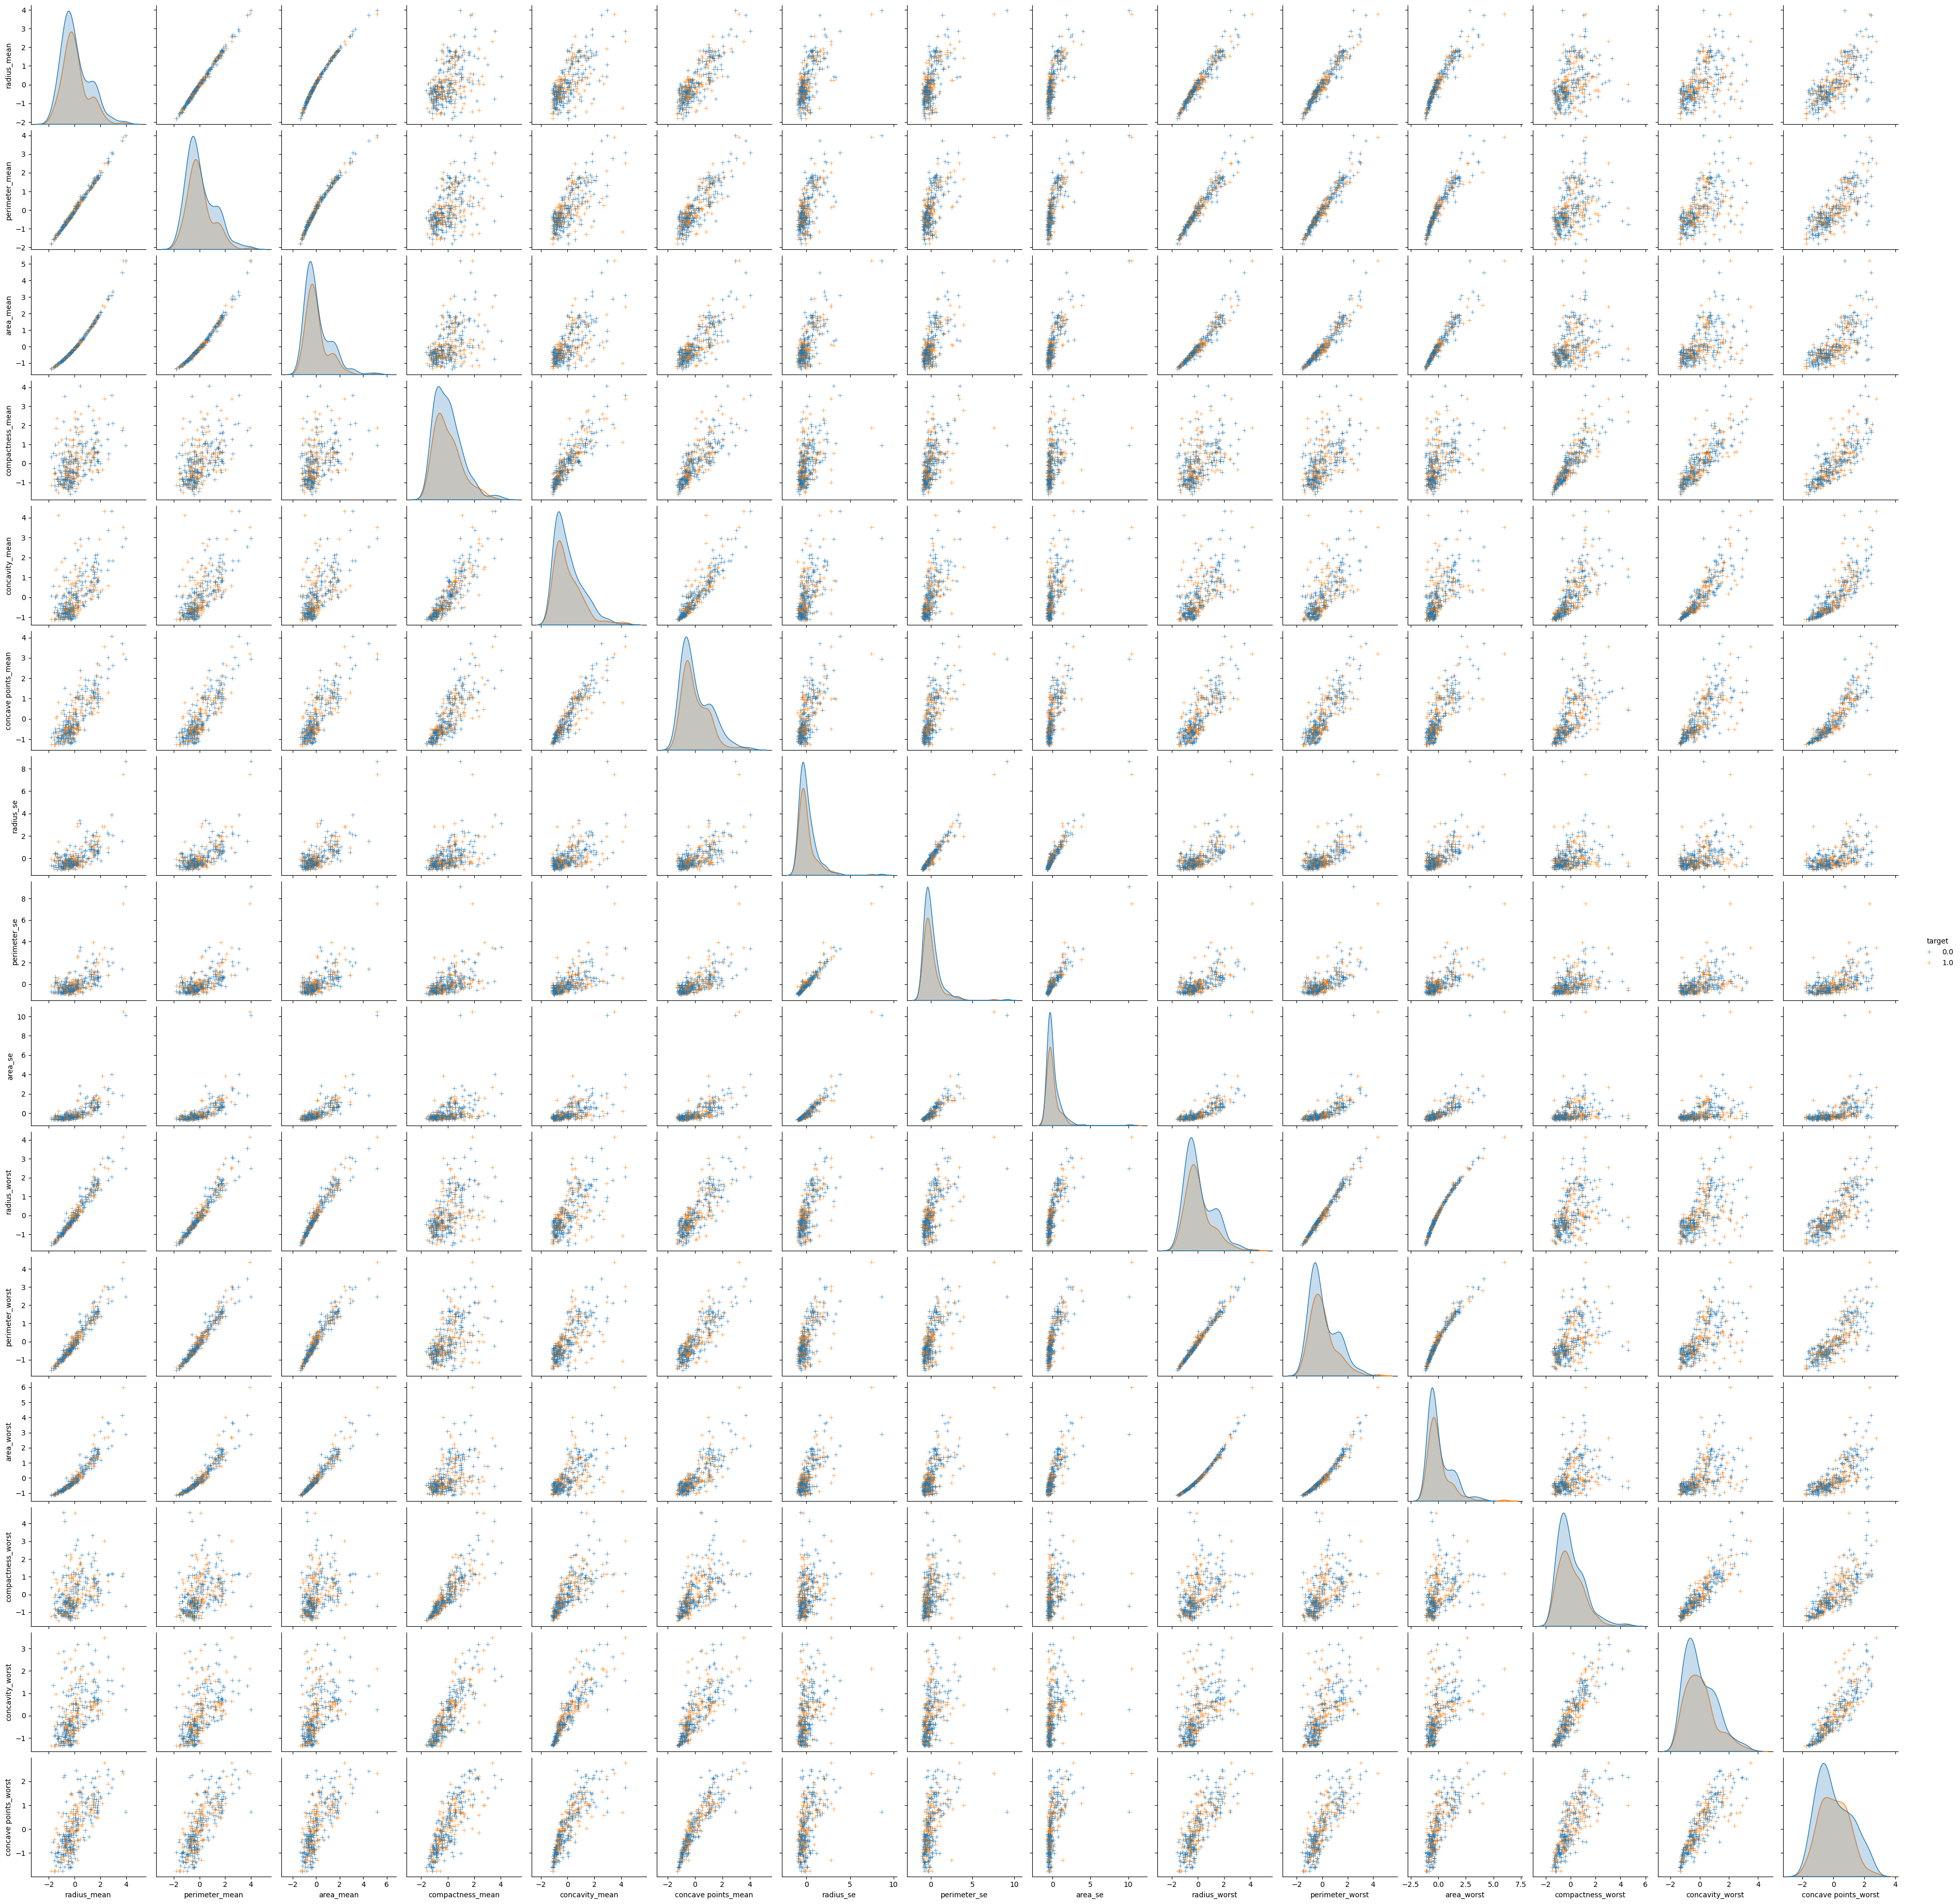

In [29]:
# pair plot 
sns.pairplot(X_train_df[corr_features], diag_kind = "kde", markers = "+",hue = "target")
plt.show()

In [30]:
# %% Basic KNN Method

knn = KNeighborsClassifier(n_neighbors = 2)
knn.fit(X_train, Y_train)
y_pred = knn.predict(X_test)
cm = confusion_matrix(Y_test, y_pred)
acc = accuracy_score(Y_test, y_pred)
score = knn.score(X_test, Y_test)
print("Score: ",score)
print("CM: ",cm)
print("Basic KNN Acc: ",acc)

Score:  0.958041958041958
CM:  [[88  1]
 [ 5 49]]
Basic KNN Acc:  0.958041958041958


In [31]:
def KNN_Best_Params(x_train, x_test, y_train, y_test):
    
    k_range = list(range(1,31))
    weight_options = ["uniform","distance"]
    print()
    param_grid = dict(n_neighbors = k_range, weights = weight_options)
    
    knn = KNeighborsClassifier()
    grid = GridSearchCV(knn, param_grid, cv = 10, scoring = "accuracy")
    grid.fit(x_train, y_train)
    
    print("Best training score: {} with parameters: {}".format(grid.best_score_, grid.best_params_))
    print()
    
    knn = KNeighborsClassifier(**grid.best_params_)
    knn.fit(x_train, y_train)
    
    y_pred_test = knn.predict(x_test)
    y_pred_train = knn.predict(x_train)
    
    cm_test = confusion_matrix(y_test, y_pred_test)
    cm_train = confusion_matrix(y_train, y_pred_train)
    
    acc_test = accuracy_score(y_test, y_pred_test)
    acc_train = accuracy_score(y_train, y_pred_train)
    print("Test Score: {}, Train Score: {}".format(acc_test, acc_train))
    print()
    print("CM Test: ",cm_test)
    print("CM Train: ",cm_train)
    
    return grid

In [32]:
grid = KNN_Best_Params(X_train, X_test, Y_train, Y_test)



Best training score: 0.9646733111849392 with parameters: {'n_neighbors': 10, 'weights': 'distance'}

Test Score: 0.965034965034965, Train Score: 1.0

CM Test:  [[86  3]
 [ 2 52]]
CM Train:  [[268   0]
 [  0 158]]


In [33]:
# %% PCA

scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)


Text(0.5, 1.0, 'PCA: p1 vs p2')

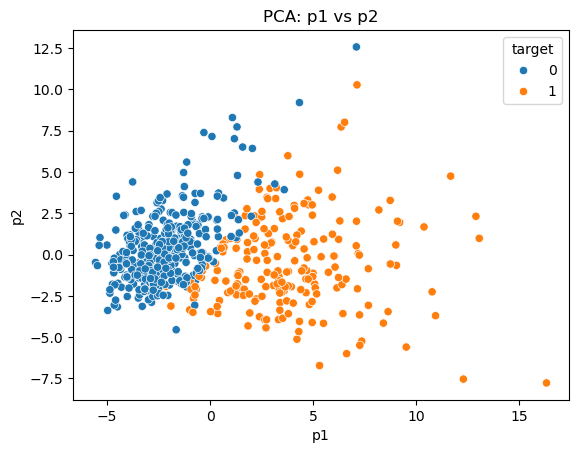

In [34]:
pca = PCA(n_components = 2)
pca.fit(x_scaled)
X_reduced_pca = pca.transform(x_scaled)
pca_data = pd.DataFrame(X_reduced_pca, columns = ["p1","p2"])
pca_data["target"] = y
sns.scatterplot(x = "p1", y = "p2", hue = "target", data = pca_data)
plt.title("PCA: p1 vs p2")

In [35]:
X_train_pca, X_test_pca, Y_train_pca, Y_test_pca = train_test_split(X_reduced_pca, y, test_size = test_size, random_state = 42)

In [36]:
grid_pca = KNN_Best_Params(X_train_pca, X_test_pca, Y_train_pca, Y_test_pca)


Best training score: 0.9342746400885936 with parameters: {'n_neighbors': 13, 'weights': 'uniform'}

Test Score: 0.958041958041958, Train Score: 0.9413145539906104

CM Test:  [[86  3]
 [ 3 51]]
CM Train:  [[260   8]
 [ 17 141]]


In [37]:
# visualize 
cmap_light = ListedColormap(['orange',  'cornflowerblue'])
cmap_bold = ListedColormap(['darkorange', 'darkblue'])

In [38]:
h = .05 # step size in the mesh
X = X_reduced_pca
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

In [39]:
Z = grid_pca.predict(np.c_[xx.ravel(), yy.ravel()])

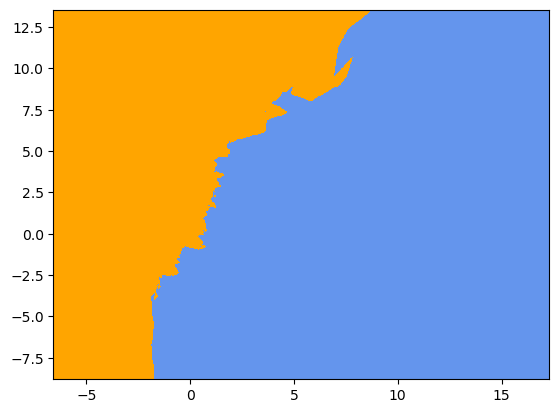

In [40]:
# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure()
plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

Text(0.5, 1.0, "2-Class classification (k = 13, weights = 'uniform')")

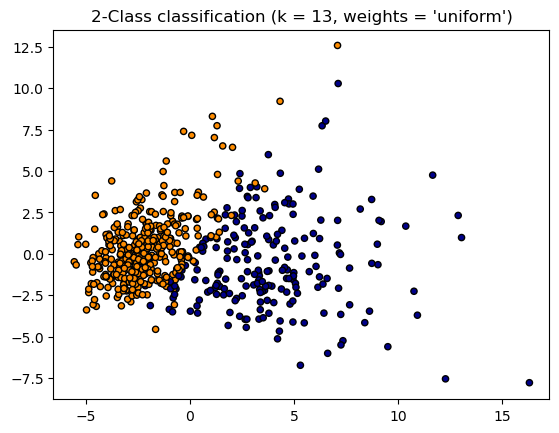

In [41]:
# Plot also the training points
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold,
            edgecolor='k', s=20)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.title("%i-Class classification (k = %i, weights = '%s')"
          % (len(np.unique(y)),grid_pca.best_estimator_.n_neighbors, grid_pca.best_estimator_.weights))

Text(0.5, 1.0, 'NCA: p1 vs p2')

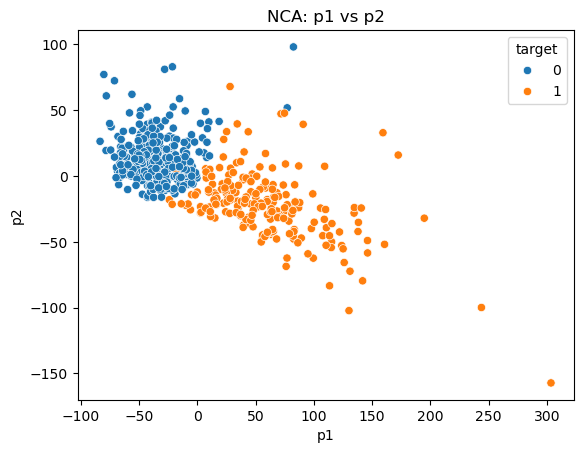

In [42]:
#%% NCA

nca = NeighborhoodComponentsAnalysis(n_components = 2, random_state = 42)
nca.fit(x_scaled, y)
X_reduced_nca = nca.transform(x_scaled)
nca_data = pd.DataFrame(X_reduced_nca, columns = ["p1","p2"])
nca_data["target"] = y
sns.scatterplot(x = "p1",  y = "p2", hue = "target", data = nca_data)
plt.title("NCA: p1 vs p2")

In [43]:
X_train_nca, X_test_nca, Y_train_nca, Y_test_nca = train_test_split(X_reduced_nca, y, test_size = test_size, random_state = 42)

In [44]:
grid_nca = KNN_Best_Params(X_train_nca, X_test_nca, Y_train_nca, Y_test_nca)


Best training score: 0.9882059800664452 with parameters: {'n_neighbors': 1, 'weights': 'uniform'}

Test Score: 0.986013986013986, Train Score: 1.0

CM Test:  [[88  1]
 [ 1 53]]
CM Train:  [[268   0]
 [  0 158]]


In [45]:
# visualize 
cmap_light = ListedColormap(['orange',  'cornflowerblue'])
cmap_bold = ListedColormap(['darkorange', 'darkblue'])

In [46]:
h = .2 # step size in the mesh
X = X_reduced_nca
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))


In [47]:
Z = grid_nca.predict(np.c_[xx.ravel(), yy.ravel()])

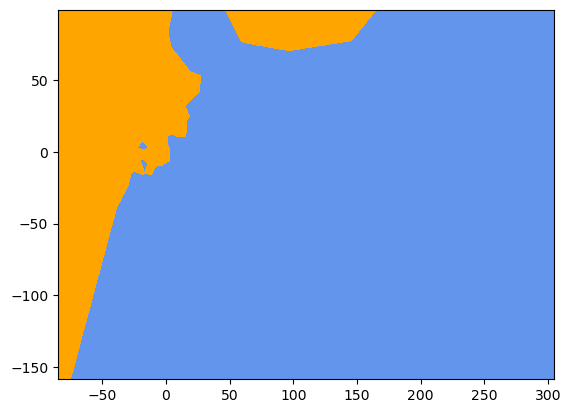

In [48]:
# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure()
plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

Text(0.5, 1.0, "2-Class classification (k = 1, weights = 'uniform')")

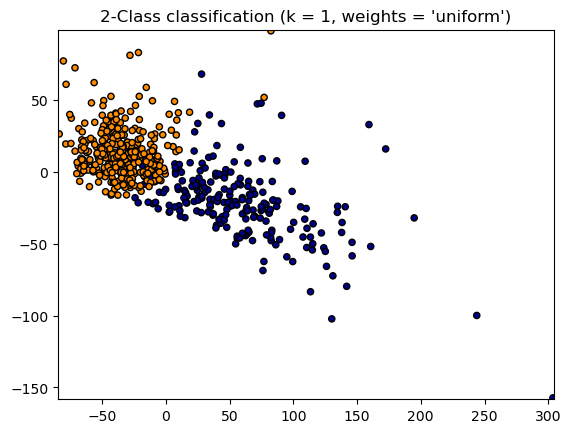

In [49]:
# Plot also the training points
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold,
            edgecolor='k', s=20)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.title("%i-Class classification (k = %i, weights = '%s')"
          % (len(np.unique(y)),grid_nca.best_estimator_.n_neighbors, grid_nca.best_estimator_.weights))


In [50]:
# %% find wrong decision
knn = KNeighborsClassifier(**grid_nca.best_params_)
knn.fit(X_train_nca,Y_train_nca)
y_pred_nca = knn.predict(X_test_nca)
acc_test_nca = accuracy_score(y_pred_nca,Y_test_nca)
knn.score(X_test_nca,Y_test_nca)

0.986013986013986

In [51]:
test_data = pd.DataFrame()
test_data["X_test_nca_p1"] = X_test_nca[:,0]
test_data["X_test_nca_p2"] = X_test_nca[:,1]
test_data["y_pred_nca"] = y_pred_nca
test_data["Y_test_nca"] = Y_test_nca

<Axes: xlabel='X_test_nca_p1', ylabel='X_test_nca_p2'>

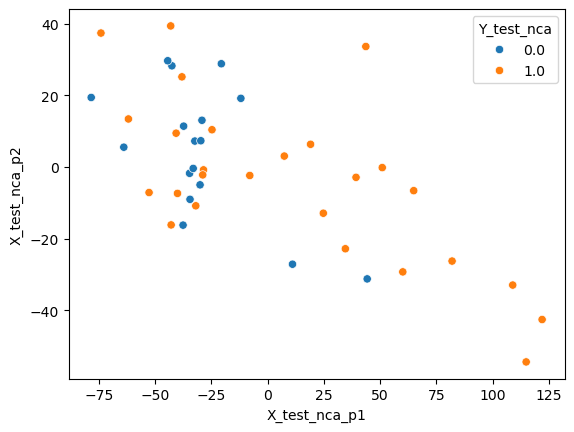

In [52]:
plt.figure()
sns.scatterplot(x="X_test_nca_p1", y="X_test_nca_p2", hue="Y_test_nca",data=test_data)

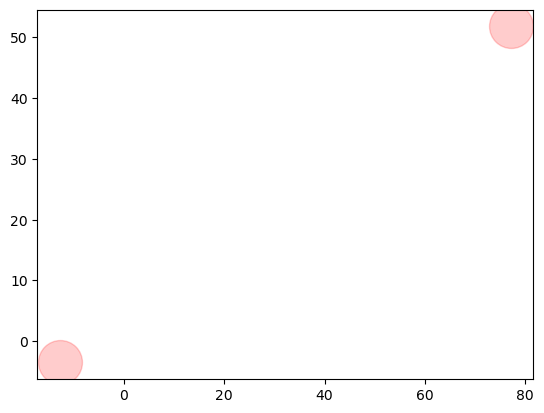

In [54]:
diff = np.where(y_pred_nca!=Y_test_nca)[0]
plt.scatter(test_data.iloc[diff,0],test_data.iloc[diff,1],label = "Wrong Classified",alpha = 0.2,color = "red",s = 1000)